In [1]:
import autograd.numpy as np
from autograd import grad
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""
    
    def unpack_kernel_params(params):
        mean        = params[0]
        cov_params  = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale
    
    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean + np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        # Calculate predictive covariance
        return pred_mean, pred_cov
    
    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        return mvn.logpdf(y, prior_mean, cov_y_y)
    
    return num_cov_params + 2, predict, log_marginal_likelihood

In [2]:
# Define a covariance function.
def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x /lengthscales, 1)\
          - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))

def per_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    period = np.exp(kernel_params[1])
    diffs = np.expand_dims(x, 1) - np.expand_dims(xp, 0)
    per_diffs = np.sum(np.sin(np.pi*np.abs(diffs)/period)**2, axis=2)
    return output_scale * np.exp(-2*per_diffs)

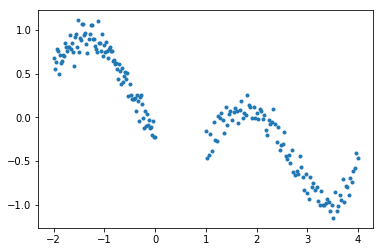

In [3]:
def build_toy_dataset(D=1, n_data=50, noise_std=0.25):
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 4, num=n_data/2),
                              np.linspace(6, 12, num=n_data/2)])
    targets = (np.cos(inputs/3) + np.sin(inputs) + rs.randn(n_data) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs  = inputs.reshape((len(inputs), D))
    return inputs, targets

D = 1
n_data = 200
noise_std=0.2
X, y = build_toy_dataset(D=D, n_data=n_data, noise_std=noise_std)

plt.plot(X,y,'.')

In [4]:
## SPOILER ALERT ##
# Code below is super useful, but does all the rest of the work for you!!!

In [5]:
##Use this nifty code to optimize
# Build model and objective function.
num_params, predict, log_marginal_likelihood = make_gp_funs(rbf_covariance, num_cov_params=D + 1)
# num_params, predict, log_marginal_likelihood = make_gp_funs(per_covariance, num_cov_params=D + 1)
#objective = lambda params: -log_marginal_likelihood(params, X, y)
# Initialize covariance parameters
rs = npr.RandomState(0)
init_params = .1 * rs.randn(num_params)
# Optimize using conjugate gradients
#opt_params = minimize(value_and_grad(objective), init_params, jac=True, method='CG')
#params = opt_params.x
training_gradient_fun = grad(log_marginal_likelihood, argnum=0)
init_params = .1 * rs.randn(num_params)
p = init_params.copy()
for i in range(1000):
    print(log_marginal_likelihood(p, X, y))
    p -= training_gradient_fun(p, X, y)*.0001

print(init_params)
print(p)

-186.75792479423683
-185.84377998675677
-184.92988248823136
-184.0162339337515
-183.1028359749493
-182.18969028012594
-181.2767985343806
-180.36416243973943
-179.45178371528633
-178.53966409729347
-177.62780533935327
-176.7162092125108
-175.80487750539686
-174.8938120243622
-173.98301459361224
-173.07248705534226
-172.16223126987418
-171.25224911579318
-170.34254249008563
-169.43311330827765
-168.5239635045745
-167.61509503200037
-166.70650986253946
-165.7982099872774
-164.89019741654374
-163.9824741800548
-163.07504232705776
-162.167903926475
-161.2610610670497
-160.35451585749166
-159.44827042662433
-158.54232692353224
-157.63668751770936
-156.73135439920821
-155.8263297787895
-154.9216158880729
-154.017214979688
-153.11312932742644
-152.20936122639435
-151.30591299316637
-150.40278696593901
-149.499985504686
-148.5975109913135
-147.6953658298167
-146.7935524464363
-145.8920732898166
-144.99093083116324
-144.09012756440268
-143.1896660063416
-142.2895486968273
-141.3897781989085
-140

(-3, 6)

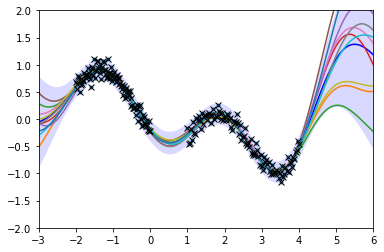

In [7]:
## Use this nifty code to plot
# Show posterior marginals.
params = p
plot_xs = np.reshape(np.linspace(-7, 7, 300), (300,1))
pred_mean, pred_cov = predict(params, X, y, plot_xs)
obs_var = np.exp(params[1]) + 0.0001
marg_std = np.sqrt(np.diag(pred_cov) + obs_var)
plt.plot(plot_xs, pred_mean, 'b')
plt.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
        np.concatenate([pred_mean - 1.96 * marg_std,
                       (pred_mean + 1.96 * marg_std)[::-1]]),
        alpha=.15, fc='Blue', ec='None')
plt.plot(X,y,'.')

# Show samples from posterior.
rs = npr.RandomState(0)
sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
plt.plot(plot_xs, sampled_funcs.T)

plt.plot(X, y, 'kx')
plt.ylim([-2, 2])
plt.xlim([-3, 6])